In [1]:
#### MAY NEED TO REMOVE --> THESE IMPORTS ARE JUST FOR MY DEPENDENCIES ON MY LOCAL DEVICE
import sys 
sys.path.append('../..')
######

from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import matplotlib.pyplot as plt
import seaborn as sns
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm.autonotebook import tqdm as tqdm
from abc import ABC
import IPython
import os
import config

from delphi import train
from delphi import oracle
import delphi.utils.constants as consts
from delphi import grad
# set environment variable so that stores can create output files

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

if ch.cuda.is_available(): 
    ch.set_default_tensor_type(ch.cuda.FloatTensor)
    print("cuda tensors...")
    

# CONSTANTS
EXP_NAME = 'SGD1Million.'
SOFTMAX_REGRESSION_STORE_PATH = '/home/gridsan/stefanou/SoftmaxRegression/' + EXP_NAME

# tables
STANDARD_STORE_TABLE = 'standard_table'
TRUNCATED_STORE_TABLE = 'truncated_table'
GUMBEL_CE_TABLE = 'gumbel_table'

STANDARD_EVAL_TABLE = 'standard_eval_table'
TRUNCATED_EVAL_TABLE = 'truncated_eval_table'
GUMBEL_EVAL_TABLE = 'gumbel_eval_table'


TRUNC_TRUTH_TABLE ='truncated_truth_table'
NAIVE_TRUTH_TABLE = 'naive_truth_table'

/home/gridsan/stefanou/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Algorithm and Experiment Hyperparameters

In [9]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 1000,
    'num_workers': 8, 
    'batch_size': 64,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-2,
    'shuffle': False, 
    'samples': 1000000,  # number of samples to generate for ground truth
    'in_features': 2, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'trials': 1,
    'log_iters': 1,    
    'should_save_ckpt': True,
    'save_ckpt_iters': -1,
    'validation_split': .8,
    'momentum': 0,
    'weight_decay': 0,
    'custom_lr_multiplier': consts.COSINE,
    'shuffle': True,
    'alpha_thresh': .5,
    'tol': 1e-5,
    'accuracy': True,
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("cuda available...")
else: 
    args.__setattr__('device', 'cpu')
args

{
  "epochs": 1000,
  "num_workers": 8,
  "batch_size": 64,
  "bias": true,
  "num_samples": 1000,
  "clamp": true,
  "radius": 5.0,
  "lr": 0.01,
  "shuffle": true,
  "samples": 1000000,
  "in_features": 2,
  "k": 2,
  "lower": -1,
  "upper": 1,
  "trials": 1,
  "log_iters": 1,
  "should_save_ckpt": true,
  "save_ckpt_iters": -1,
  "validation_split": 0.8,
  "momentum": 0,
  "weight_decay": 0,
  "custom_lr_multiplier": "cosine",
  "alpha_thresh": 0.5,
  "tol": 1e-05,
  "accuracy": true,
  "device": "cpu"
}

# Training and Evaluation Procedure Functions

In [4]:
class epoch_hook: 
    """
    End epoch hook for training procedure. 
    """
    def __init__(self, store, table_name=None, ground_truth=None): 
        # model ground truth
        self.gt_params = None
        if ground_truth is not None: 
            self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)
        self.store = store
        
        # check for different table name
        self.table_name = table_name
        if not table_name: 
            self.table_name = 'ground_truth_table'
        self.store.add_table(self.table_name, { 
            'cos_sim': float, 
            'l2': float,
            'epoch': int,
        })
        
    # set ground_truth for exp
    def set_ground_truth(self, ground_truth): 
        self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)

    def __call__(self, model, epoch): 
        # current model parameters
        trunc_params = ch.cat([model.weight.flatten(), model.bias]).unsqueeze(1).cpu()
        # cosine similarity and l2 distance
        cos_sim = float(ch.nn.functional.cosine_similarity(self.gt_params, trunc_params, dim=0))
        l2_dist = float(ch.nn.MSELoss()(self.gt_params, trunc_params))

        ground_truth_info = { 
            'epoch': epoch + 1, 
            'cos_sim': cos_sim, 
            'l2': l2_dist,
        }

        self.store[self.table_name].append_row(ground_truth_info)

# Oracles

In [5]:
lower = oracle.DNN_Lower(ch.full(ch.Size([args.K,]), -2, dtype=ch.float32))
id_ = oracle.Identity()
ball = oracle.DNN_Logit_Ball(ch.full(ch.Size([args.K,]), -1, dtype=ch.float32), ch.full(ch.Size([args.K,]), 1, dtype=ch.float32))

# Experiment

In [6]:
def gen_data(): 
    """
    Generate dataset for truncated multinomial logistic 
    regression model. Returns ground_truth and train, validation, and test loaders.
    """
    # distributions
    gumbel = Gumbel(0, 1)
    U = Uniform(args.lower, args.upper) # distribution to generate ground-truth parameters
    U_ = Uniform(-5, 5) # distribution to generate samples
    
    # no grad required for dataset
    with ch.no_grad():
        # generate synthetic data until survival probability of more than 40%
        alpha = None
        while alpha is None or alpha < args.ALPHA_THRESH:
            # generate ground-truth from uniform distribution
            ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
            ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
            if ground_truth.bias is not None: 
                ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
            # independent variable 
            X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
            # determine base model logits 
            z = ground_truth(X)
            # add noise to the logits
            noised = z + gumbel.sample(z.size())
            # apply softmax to unnormalized likelihoods
            y = ch.argmax(noised, dim=1)

            # TRUNCATE
            trunc = args.phi(z)
            indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
            x_trunc, y_trunc = X[indices].cpu(), y[indices].cpu()
            alpha = x_trunc.size(0) / X.size(0)
            
        print("alpha: {}".format(alpha))

        # all synthetic data 
        ds = TensorDataset(x_trunc, y_trunc)
        # split ds into training and validation data sets - 80% training, 20% validation
        train_length = int(len(ds)*.8)
        val_length = len(ds) - train_length
        train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
        # train and validation loaders
        train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
        val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)

        # test dataset
        x_test = X[~indices].cpu()
        y_test = y[~indices].cpu()
        test_ds = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_ds, num_workers=args.num_workers, batch_size=args.batch_size)
            
    return ground_truth, (train_loader, val_loader), test_loader

In [7]:
# set truncation oracle
args.__setattr__('phi', id_)
# gradients
gumbel_ce = grad.GumbelCE.apply
logistic_bce = grad.LogisticBCE.apply
trunc_bce = grad.TruncatedBCE.apply
trunc_ce = grad.TruncatedCE.apply

In [14]:
# for lr in [2e-1, 1e-1, 1e-2, 1e-3]: 
    # name store based off of learnign rate and adam
#     args.__setattr__('lr', lr)
store_path = SOFTMAX_REGRESSION_STORE_PATH

# perform number of trials experiments
for i in range(args.trials):
    out_store = Store(store_path)
    # create store
    trunc_epoch_hook = epoch_hook(out_store, table_name=TRUNC_TRUTH_TABLE)
    naive_epoch_hook = epoch_hook(out_store, table_name=NAIVE_TRUTH_TABLE)

    # determine exp completion based off of score
    args.__setattr__('score', True)
    # generate data for exp
    ground_truth, loaders, test_loader = gen_data()
    # set ground-truth
    trunc_epoch_hook.set_ground_truth(ground_truth)
    args.__setattr__('epoch_hook', trunc_epoch_hook)
    
    # set initial manual seed, so that procedures start from same point
    torch.manual_seed(0)

    # new classifier models at the beginning of each trial
    trunc_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

    args.__setattr__('custom_criterion', trunc_ce)  # truncated ce loss
    config.args = args # set global args
    train.train_model(args, trunc_multi_log_reg, loaders, store=out_store, table=TRUNCATED_STORE_TABLE)

    # set ground-truth
    naive_epoch_hook.set_ground_truth(ground_truth)
    args.__setattr__('epoch_hook', naive_epoch_hook)
    
    # set initial manual seed, so that procedures start from same point
    torch.manual_seed(0)

    # new classifier models at the beginning of each trial
    standard_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

    # naive ce loss
    args.__setattr__('custom_criterion', ch.nn.CrossEntropyLoss()) # default ce loss
    config.args = args # set global args
    train.train_model(args, standard_multi_log_reg, loaders, store=out_store, 
                table=STANDARD_STORE_TABLE)

    # standard multinomial logistic regression eval - if there is a test set
    if len(test_loader) > 0 and False:
        args.__setattr__('score', False)
        # truncated multinomial logistic regression eval
        config.args = args # set global args
        train.eval_model(args, trunc_multi_log_reg, test_loader, out_store, table=TRUNCATED_EVAL_TABLE)

        # standard multinomial logistic regression eval
        config.args = args # set global args
        train.eval_model(args, standard_multi_log_reg, test_loader, out_store, table=STANDARD_EVAL_TABLE)

    IPython.display.clear_output(wait=False)


    # close store after experiment
    out_store.close()

Logging in: /home/gridsan/stefanou/SoftmaxRegression/SGD1Million./baa21184-1a2f-4dd3-8d5f-67117fea3ade
indices:  tensor([      -1,       -2,       -3,  ...,  -999998,  -999999, -1000000])
alpha: 1.0


KeyboardInterrupt: 

# Plot Results

100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


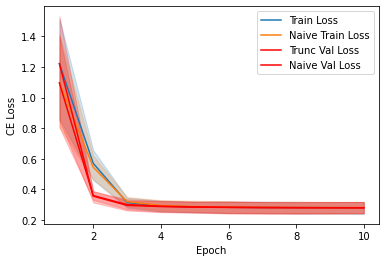

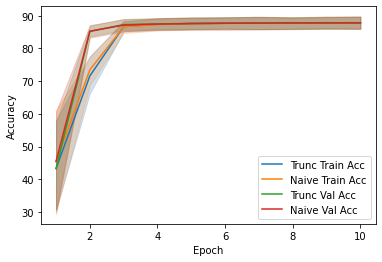

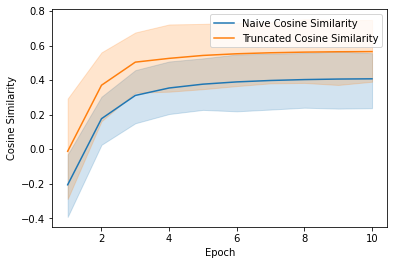

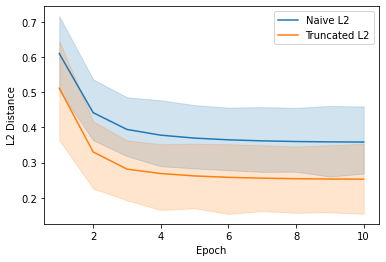

Standard Test Accuracy: 0    86.892998
0    84.180000
0    86.736000
0    90.993996
0    84.670998
0    90.739998
0    84.765999
0    89.836998
0    91.674995
Name: test_prec1, dtype: float64
Truncated Test Accuracy: 0    86.855995
0    84.267998
0    86.702995
0    91.278000
0    84.739998
0    90.577995
0    84.700996
0    89.661995
0    91.704994
Name: test_prec1, dtype: float64


In [41]:
# read results form 
reader = CollectionReader(SOFTMAX_REGRESSION_STORE_PATH + '001')

# TRUNCATED CE LOSS DATA
trunc_logs = reader.df(TRUNCATED_STORE_TABLE)
trunc_truth_table = reader.df(TRUNC_TRUTH_TABLE)
# STANDARD CE LOSS DATA
standard_logs = reader.df(STANDARD_STORE_TABLE)
standard_truth_table = reader.df(NAIVE_TRUTH_TABLE)

sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='Train Loss')
sns.lineplot(data=standard_logs, x='epoch', y='train_loss', label='Naive Train Loss')
sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', color='red', label='Trunc Val Loss')
ax = sns.lineplot(data=standard_logs, x='epoch', y='val_loss', color='red', label='Naive Val Loss')
ax.set(xlabel='Epoch', ylabel='CE Loss')
plt.show()

sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='Trunc Train Acc')
sns.lineplot(data=standard_logs, x='epoch', y='train_prec1', label='Naive Train Acc')
sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='Trunc Val Acc')
ax = sns.lineplot(data=standard_logs, x='epoch', y='val_prec1', label='Naive Val Acc')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=standard_truth_table, x='epoch', y='cos_sim', label='Naive Cosine Similarity')
ax = sns.lineplot(data=trunc_truth_table, x='epoch', y='cos_sim', label='Truncated Cosine Similarity')
ax.set(xlabel='Epoch', ylabel='Cosine Similarity')
plt.show()

sns.lineplot(data=standard_truth_table, x='epoch', y='l2', label='Naive L2')
ax = sns.lineplot(data=trunc_truth_table, x='epoch', y='l2', label='Truncated L2')
ax.set(xlabel='Epoch', ylabel='L2 Distance')
plt.show()

try: 
    # STANDARD TEST SET RESULTS 
    standard_test_results = reader.df(STANDARD_EVAL_TABLE)

    # TRUNCATED TEST SET RESULTS 
    trunc_test_results = reader.df(TRUNCATED_EVAL_TABLE)

    print("Standard Test Accuracy: {}".format(standard_test_results['test_prec1']))
    print("Truncated Test Accuracy: {}".format(trunc_test_results['test_prec1']))
except: 
    print("No Test Results to Report")

reader.close() # close reader

In [8]:
reader = CollectionReader(SOFTMAX_REGRESSION_STORE_PATH + '1')

reader.df('standard_eval_table')

100%|██████████| 10/10 [00:00<00:00, 28.01it/s]


,test_prec1,test_loss,time,exp_id
0,91.403999,0.199612,4.847414,795dfce2-3add-4031-8c54-9452c723059c
0,84.569000,0.345661,5.236000,469e0d10-9401-4e5e-b12a-cb50ef9a9982
0,69.039001,0.590696,5.087705,b06e45d4-cdd4-4ef2-b4b6-e601cb7df6f7
0,82.394997,0.396119,5.555217,5f6e5e71-8dab-47df-9920-06ed86630fae
0,92.938995,0.168385,6.039914,c12b5f65-6fae-42c9-9b70-46ca8cb542c7
0,84.143997,0.348097,4.212301,27b925bb-ca86-4524-ba01-5060d1aba3b3
0,87.103996,0.300245,4.495728,13e42da2-12e8-4cf1-82ce-d27210fac2e2
0,83.633995,0.372687,6.001090,ce6a55bd-fdec-47c8-98a5-3d3ecce42e02
0,75.445999,0.501461,5.411064,50564d40-3780-4030-8805-4bfc0cb6eac4
0,83.624001,0.359499,4.805259,9512d18c-ae4e-4423-a126-642a6378ce04


In [11]:
opt = SGD(ch.nn.Linear(in_features=2, out_features=1).parameters(), lr=1e-1)

In [13]:
opt.param_groups[0]['lr']

[{'params': [Parameter containing:
   tensor([[0.6040, 0.5480]], requires_grad=True),
   Parameter containing:
   tensor([0.3807], requires_grad=True)],
  'lr': 0.1,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False}]

In [10]:
weight_grad = Tensor([-0.1491,  0.1493])

In [11]:
weight_grad / weight_grad.norm()

tensor([-0.7066,  0.7076])

In [8]:
import torch

print("Print 5 random numbers")
print(torch.rand(5))

print("Set the starting point to 15678 (this could be any integer number)")
torch.manual_seed(10)

print("Print 5 random numbers")
print(torch.rand(5))

print("Print 5 more random numbers")
print(torch.rand(5))

print("Set the starting point to 15678 again")
torch.manual_seed(10)

print("Print 5 random numbers")
print(torch.rand(5))

Print 5 random numbers
tensor([0.4395, 0.9383, 0.1213, 0.3481, 0.1033])
Set the starting point to 15678 (this could be any integer number)
Print 5 random numbers
tensor([0.4581, 0.4829, 0.3125, 0.6150, 0.2139])
Print 5 more random numbers
tensor([0.4118, 0.6938, 0.9693, 0.6178, 0.3304])
Set the starting point to 15678 again
Print 5 random numbers
tensor([0.4581, 0.4829, 0.3125, 0.6150, 0.2139])


In [10]:
torch.manual_seed(0)

layer_1 = ch.nn.Linear(in_features=2, out_features=1)
print("layer 1 weights: ", layer_1.weight)

layer_2 = ch.nn.Linear(in_features=2, out_features=1)
print("layer 2 weights: ", layer_2.weight)


torch.manual_seed(0)


layer_3 = ch.nn.Linear(in_features=2, out_features=1)
print("layer 2 weights: ", layer_3.weight)

layer 1 weights:  Parameter containing:
tensor([[-0.0053,  0.3793]], requires_grad=True)
layer 2 weights:  Parameter containing:
tensor([[-0.5204, -0.2723]], requires_grad=True)
layer 2 weights:  Parameter containing:
tensor([[-0.0053,  0.3793]], requires_grad=True)


In [8]:
ground_truth, loaders, test_loader = gen_data()

alpha: 1.0


In [12]:
for batch in loaders[0]: 
    X, y = batch
    break

In [17]:
ch.max(loaders[0].dataset + 1)

tensor(2)

In [24]:
for i in : 
    print(i)


(tensor([-2.4436, -4.7683]), tensor(0))
(tensor([-0.4491, -3.7950]), tensor(1))
(tensor([-4.6084,  4.3131]), tensor(0))
(tensor([-4.9686,  0.5744]), tensor(0))
(tensor([-1.9901,  4.5388]), tensor(0))
(tensor([-0.1569,  1.2980]), tensor(0))
(tensor([ 0.3324, -0.0839]), tensor(1))
(tensor([ 3.3668, -1.2197]), tensor(1))
(tensor([-1.3010, -0.4845]), tensor(0))
(tensor([ 4.6460, -4.9315]), tensor(1))
(tensor([-3.5731,  4.5600]), tensor(0))
(tensor([ 4.4697, -2.2076]), tensor(1))
(tensor([-2.9243,  1.8932]), tensor(0))
(tensor([ 2.0767, -3.5677]), tensor(1))
(tensor([2.3764, 4.8173]), tensor(1))
(tensor([-0.7556,  4.1590]), tensor(0))
(tensor([ 2.6034, -0.9001]), tensor(1))
(tensor([-3.7591, -3.4657]), tensor(1))
(tensor([-3.7730,  0.8638]), tensor(0))
(tensor([-2.4840,  3.3006]), tensor(0))
(tensor([2.7923, 4.5995]), tensor(1))
(tensor([-3.4648,  1.4567]), tensor(0))
(tensor([-3.3681,  4.8223]), tensor(0))
(tensor([-4.7662,  4.4168]), tensor(0))
(tensor([ 1.8780, -3.4098]), tensor(1))
(ten

(tensor([2.4205, 1.8024]), tensor(1))
(tensor([4.5988, 2.9849]), tensor(1))
(tensor([1.6017, 0.5455]), tensor(1))
(tensor([-1.9281,  1.7944]), tensor(0))
(tensor([2.4490, 4.0686]), tensor(1))
(tensor([ 3.3224, -4.1968]), tensor(1))
(tensor([ 3.9009, -1.7337]), tensor(1))
(tensor([-2.2787,  1.2292]), tensor(0))
(tensor([2.8992, 0.3502]), tensor(1))
(tensor([-2.0216,  3.0598]), tensor(1))
(tensor([ 0.2390, -4.2995]), tensor(1))
(tensor([-1.7943, -4.5582]), tensor(0))
(tensor([2.2140, 1.7536]), tensor(1))
(tensor([-1.9131,  0.6786]), tensor(0))
(tensor([-2.7276, -0.6700]), tensor(0))
(tensor([ 1.6960, -2.4094]), tensor(1))
(tensor([-1.1289,  0.6593]), tensor(1))
(tensor([ 2.1983, -3.0720]), tensor(1))
(tensor([-0.5471, -3.2428]), tensor(1))
(tensor([4.8990, 2.2514]), tensor(1))
(tensor([-4.1035,  0.0210]), tensor(0))
(tensor([-0.3847, -1.8746]), tensor(1))
(tensor([-4.0146, -4.6359]), tensor(0))
(tensor([-1.0494,  4.4025]), tensor(0))
(tensor([-1.1303,  2.2993]), tensor(0))
(tensor([4.818

(tensor([-4.7142,  4.0849]), tensor(0))
(tensor([3.8780, 2.7090]), tensor(1))
(tensor([1.5060, 4.1357]), tensor(0))
(tensor([-4.8539,  1.2618]), tensor(0))
(tensor([-2.9430,  2.3462]), tensor(0))
(tensor([0.6816, 0.9228]), tensor(1))
(tensor([-4.2671, -1.6849]), tensor(0))
(tensor([-2.3856,  3.1764]), tensor(1))
(tensor([-4.8221, -2.6424]), tensor(0))
(tensor([3.4799, 1.9959]), tensor(1))
(tensor([2.8153, 4.0324]), tensor(1))
(tensor([-2.1768,  4.8748]), tensor(0))
(tensor([ 3.7904, -0.2005]), tensor(1))
(tensor([1.8327, 1.1634]), tensor(1))
(tensor([-3.1100, -0.6595]), tensor(1))
(tensor([2.8807, 4.3114]), tensor(1))
(tensor([-3.3518, -3.6546]), tensor(1))
(tensor([ 0.0086, -4.0313]), tensor(1))
(tensor([ 2.5607, -0.6253]), tensor(1))
(tensor([ 0.6402, -0.9199]), tensor(1))
(tensor([1.1104, 4.6203]), tensor(0))
(tensor([1.2160, 1.2986]), tensor(1))
(tensor([ 0.1878, -1.3263]), tensor(1))
(tensor([-2.9886,  0.3745]), tensor(0))
(tensor([3.9310, 2.7830]), tensor(1))
(tensor([-0.8901,  4

(tensor([-4.0771, -2.5393]), tensor(0))
(tensor([ 4.9841, -2.5419]), tensor(1))
(tensor([ 1.3279, -3.7835]), tensor(1))
(tensor([1.0642, 4.4241]), tensor(1))
(tensor([3.6464, 2.8471]), tensor(1))
(tensor([3.8166, 2.0220]), tensor(1))
(tensor([-1.7369,  0.5918]), tensor(1))
(tensor([ 2.1065, -4.0910]), tensor(1))
(tensor([4.9703, 4.0676]), tensor(1))
(tensor([-2.7700,  3.9096]), tensor(0))
(tensor([2.7678, 1.4351]), tensor(1))
(tensor([-4.3935, -3.8320]), tensor(0))
(tensor([-0.4039,  0.9241]), tensor(0))
(tensor([-1.4894,  0.4967]), tensor(1))
(tensor([-3.9340, -4.0597]), tensor(0))
(tensor([0.2309, 4.7483]), tensor(0))
(tensor([-3.8918, -0.9778]), tensor(0))
(tensor([-1.0484, -0.1105]), tensor(0))
(tensor([ 0.5809, -2.5019]), tensor(1))
(tensor([-0.5779, -3.9600]), tensor(1))
(tensor([-1.4924,  4.5556]), tensor(0))
(tensor([-4.7922,  0.7363]), tensor(0))
(tensor([4.0055, 0.7514]), tensor(1))
(tensor([ 3.6487, -0.2152]), tensor(1))
(tensor([-0.4638, -2.7254]), tensor(1))
(tensor([-3.67

(tensor([ 2.7138, -1.9355]), tensor(1))
(tensor([-3.3699, -3.0457]), tensor(0))
(tensor([-0.5642, -1.8142]), tensor(1))
(tensor([-4.2994, -4.4897]), tensor(0))
(tensor([-4.5762, -3.5273]), tensor(0))
(tensor([4.7790, 1.9735]), tensor(1))
(tensor([1.4360, 2.3040]), tensor(1))
(tensor([ 3.9585, -3.8316]), tensor(1))
(tensor([2.0429, 4.5016]), tensor(0))
(tensor([-2.1880, -2.7556]), tensor(0))
(tensor([ 1.7793, -4.9848]), tensor(1))
(tensor([-3.5827,  4.6018]), tensor(0))
(tensor([ 0.1528, -4.3965]), tensor(1))
(tensor([2.4276, 4.9566]), tensor(1))
(tensor([1.6823, 0.7524]), tensor(1))
(tensor([ 2.6607, -0.1058]), tensor(1))
(tensor([-0.8506, -2.2680]), tensor(1))
(tensor([4.7373, 4.4483]), tensor(1))
(tensor([ 0.0525, -1.2128]), tensor(1))
(tensor([-2.6898,  0.3202]), tensor(0))
(tensor([ 2.3210, -4.2845]), tensor(1))
(tensor([-2.1363,  1.0896]), tensor(0))
(tensor([3.6970, 0.3242]), tensor(1))
(tensor([-2.0702,  1.3182]), tensor(0))
(tensor([0.2702, 3.3826]), tensor(0))
(tensor([-1.5584

(tensor([ 0.1553, -4.5760]), tensor(1))
(tensor([-2.0272, -0.6571]), tensor(1))
(tensor([-3.3255,  3.8212]), tensor(0))
(tensor([-4.7387,  4.1333]), tensor(0))
(tensor([2.9868, 4.2075]), tensor(1))
(tensor([4.5560, 3.5795]), tensor(1))
(tensor([-0.7856, -3.7774]), tensor(1))
(tensor([-2.4441, -1.1192]), tensor(1))
(tensor([-2.1599,  0.4349]), tensor(0))
(tensor([-0.9590, -3.3351]), tensor(1))
(tensor([0.4848, 2.8630]), tensor(0))
(tensor([ 2.7078, -3.1570]), tensor(1))
(tensor([ 4.2542, -1.1570]), tensor(1))
(tensor([ 1.8281, -0.6899]), tensor(1))
(tensor([-1.8200,  3.7530]), tensor(0))
(tensor([0.2682, 0.3858]), tensor(1))
(tensor([-4.5850,  2.0129]), tensor(0))
(tensor([-3.9584,  3.2431]), tensor(1))
(tensor([-0.9874, -2.9152]), tensor(1))
(tensor([-4.5284,  4.6890]), tensor(0))
(tensor([-3.2381, -3.7246]), tensor(0))
(tensor([ 0.3135, -4.1206]), tensor(1))
(tensor([-4.0814, -0.4731]), tensor(0))
(tensor([ 0.7413, -3.9557]), tensor(1))
(tensor([-0.2209,  3.7387]), tensor(0))
(tensor(

(tensor([-1.5118,  4.7704]), tensor(0))
(tensor([ 2.7707, -3.4324]), tensor(1))
(tensor([ 4.2359, -4.3947]), tensor(1))
(tensor([-3.3247,  3.7839]), tensor(0))
(tensor([ 2.7183, -4.6951]), tensor(1))
(tensor([-1.8023, -0.1095]), tensor(0))
(tensor([-1.9920, -0.5324]), tensor(0))
(tensor([-2.5268,  2.4138]), tensor(0))
(tensor([-4.0030, -3.5698]), tensor(0))
(tensor([ 4.0827, -4.7627]), tensor(1))
(tensor([0.3045, 4.6159]), tensor(1))
(tensor([0.7759, 3.6674]), tensor(1))
(tensor([-3.7220, -1.6505]), tensor(0))
(tensor([2.2785, 4.7875]), tensor(1))
(tensor([-0.8106, -2.3976]), tensor(1))
(tensor([ 0.4840, -1.3815]), tensor(1))
(tensor([-0.0290,  2.7624]), tensor(0))
(tensor([4.4284, 1.8606]), tensor(1))
(tensor([ 3.6500, -0.1656]), tensor(1))
(tensor([ 4.7704, -0.2557]), tensor(1))
(tensor([-4.2860, -4.5126]), tensor(1))
(tensor([-1.8293,  2.2125]), tensor(1))
(tensor([1.5821, 4.6721]), tensor(1))
(tensor([4.8369, 1.5222]), tensor(1))
(tensor([3.8768, 0.4786]), tensor(1))
(tensor([-4.55

(tensor([-4.4529, -0.3343]), tensor(0))
(tensor([ 0.6547, -1.3319]), tensor(1))
(tensor([-0.8659, -0.2916]), tensor(1))
(tensor([0.9073, 2.1623]), tensor(1))
(tensor([-2.1746, -2.2613]), tensor(0))
(tensor([3.3240, 3.6732]), tensor(1))
(tensor([-3.0611, -1.3667]), tensor(1))
(tensor([2.9151, 3.5982]), tensor(1))
(tensor([ 0.8244, -0.2748]), tensor(1))
(tensor([2.2515, 0.9633]), tensor(1))
(tensor([-0.6265, -4.4208]), tensor(1))
(tensor([4.0972, 2.2794]), tensor(1))
(tensor([ 4.4585, -3.0269]), tensor(1))
(tensor([-3.2924,  3.8972]), tensor(0))
(tensor([ 3.9209, -3.4502]), tensor(1))
(tensor([3.3786, 0.6305]), tensor(1))
(tensor([2.9889, 2.4522]), tensor(1))
(tensor([0.7322, 3.4454]), tensor(0))
(tensor([-0.2665,  2.4071]), tensor(0))
(tensor([4.2554, 1.9729]), tensor(1))
(tensor([-1.3766,  4.9903]), tensor(0))
(tensor([-0.2178, -3.4728]), tensor(1))
(tensor([-4.8426, -4.6209]), tensor(0))
(tensor([-0.0326, -3.5553]), tensor(1))
(tensor([2.9566, 3.5948]), tensor(1))
(tensor([ 3.7015, -0

(tensor([-1.5865,  3.2049]), tensor(0))
(tensor([ 0.8170, -0.6809]), tensor(1))
(tensor([-2.1899,  0.2742]), tensor(0))
(tensor([-1.7724,  2.4209]), tensor(0))
(tensor([-0.2243,  1.0503]), tensor(0))
(tensor([3.3342, 1.2356]), tensor(1))
(tensor([-4.6301, -3.5656]), tensor(0))
(tensor([4.9880, 3.0074]), tensor(1))
(tensor([3.2937, 2.0936]), tensor(1))
(tensor([-0.5644, -3.9156]), tensor(1))
(tensor([-4.8566, -3.3323]), tensor(0))
(tensor([-0.8008, -1.8704]), tensor(1))
(tensor([3.4330, 2.1045]), tensor(1))
(tensor([-2.9385,  4.4926]), tensor(0))
(tensor([-3.0653, -2.0181]), tensor(0))
(tensor([-3.5067, -2.7486]), tensor(0))
(tensor([-2.8228,  3.2574]), tensor(0))
(tensor([1.5814, 3.1638]), tensor(1))
(tensor([-3.8907,  0.9923]), tensor(0))
(tensor([-1.0951,  3.5979]), tensor(0))
(tensor([1.0802, 3.2477]), tensor(1))
(tensor([3.5040, 3.3106]), tensor(1))
(tensor([4.5359, 0.6857]), tensor(1))
(tensor([-2.4606,  3.7070]), tensor(0))
(tensor([-3.9822, -2.2493]), tensor(0))
(tensor([2.0382,

(tensor([-1.0971,  1.2048]), tensor(0))
(tensor([-3.5775,  2.4119]), tensor(0))
(tensor([-1.0168,  2.3203]), tensor(0))
(tensor([ 4.2065, -0.7296]), tensor(1))
(tensor([-0.3280,  2.8376]), tensor(1))
(tensor([-1.9952, -3.6423]), tensor(1))
(tensor([-0.4321, -3.9346]), tensor(1))
(tensor([ 2.9710, -1.3618]), tensor(1))
(tensor([-2.1646, -2.0544]), tensor(0))
(tensor([ 2.4829, -2.5442]), tensor(1))
(tensor([ 4.0505, -4.2047]), tensor(1))
(tensor([-3.9737,  0.3896]), tensor(0))
(tensor([ 0.6439, -0.6052]), tensor(1))
(tensor([1.9875, 1.3639]), tensor(1))
(tensor([3.5847, 1.9057]), tensor(1))
(tensor([-1.6192,  0.9587]), tensor(0))
(tensor([-0.8816, -1.5359]), tensor(0))
(tensor([-3.6086,  3.0647]), tensor(0))
(tensor([4.7253, 3.9476]), tensor(1))
(tensor([4.8268, 0.4229]), tensor(1))
(tensor([ 1.5410, -3.3389]), tensor(1))
(tensor([-3.3876,  0.8810]), tensor(0))
(tensor([0.7930, 1.9869]), tensor(1))
(tensor([-3.3087, -1.9290]), tensor(0))
(tensor([ 2.4059, -0.0772]), tensor(1))
(tensor([ 

(tensor([ 4.6397, -3.2142]), tensor(1))
(tensor([-4.9715,  1.1266]), tensor(0))
(tensor([-1.3444,  3.5361]), tensor(0))
(tensor([3.3574, 2.0175]), tensor(1))
(tensor([-4.5150, -2.8198]), tensor(0))
(tensor([2.4388, 3.6587]), tensor(1))
(tensor([4.1913, 3.7129]), tensor(1))
(tensor([0.9560, 1.5429]), tensor(1))
(tensor([-4.4990, -0.2692]), tensor(0))
(tensor([-2.3635,  2.8758]), tensor(0))
(tensor([-4.3675,  1.5991]), tensor(0))
(tensor([ 2.2969, -3.6765]), tensor(1))
(tensor([-2.5759, -4.0713]), tensor(1))
(tensor([-0.7161,  0.2443]), tensor(0))
(tensor([-2.5759, -0.6156]), tensor(0))
(tensor([1.1547, 3.0946]), tensor(1))
(tensor([-0.5217, -0.6789]), tensor(1))
(tensor([ 1.6254, -1.7374]), tensor(1))
(tensor([-0.7318,  3.7950]), tensor(1))
(tensor([-4.9501,  0.6994]), tensor(0))
(tensor([ 1.1012, -0.6310]), tensor(1))
(tensor([0.7039, 2.9982]), tensor(1))
(tensor([-3.9569,  1.7680]), tensor(0))
(tensor([-3.6460,  1.1291]), tensor(0))
(tensor([4.0035, 2.4046]), tensor(1))
(tensor([3.261

(tensor([1.0034, 3.8052]), tensor(0))
(tensor([4.7016, 3.4369]), tensor(1))
(tensor([2.4201, 2.2326]), tensor(1))
(tensor([-1.8083,  0.1265]), tensor(0))
(tensor([ 0.3418, -3.8458]), tensor(1))
(tensor([ 3.5721, -3.5064]), tensor(1))
(tensor([0.3839, 1.0652]), tensor(1))
(tensor([ 4.9600, -4.8636]), tensor(1))
(tensor([-3.9360,  0.2336]), tensor(0))
(tensor([ 0.3045, -2.2749]), tensor(1))
(tensor([-1.3284, -1.5703]), tensor(1))
(tensor([ 0.9920, -1.0613]), tensor(1))
(tensor([-0.4895, -1.0008]), tensor(1))
(tensor([4.7899, 1.8200]), tensor(1))
(tensor([3.7563, 3.4218]), tensor(1))
(tensor([0.9952, 0.0840]), tensor(1))
(tensor([-3.7616,  4.2869]), tensor(0))
(tensor([ 1.6212, -1.1074]), tensor(1))
(tensor([-2.9371, -2.0318]), tensor(1))
(tensor([-4.4987,  0.3671]), tensor(0))
(tensor([-1.8945, -2.2892]), tensor(0))
(tensor([ 3.1974, -0.9158]), tensor(1))
(tensor([3.7236, 3.5869]), tensor(1))
(tensor([ 4.0323, -0.5278]), tensor(1))
(tensor([ 1.4262, -1.0502]), tensor(1))
(tensor([1.9782,

(tensor([-2.5637, -3.9645]), tensor(1))
(tensor([ 0.9028, -4.4277]), tensor(1))
(tensor([0.6543, 1.0066]), tensor(1))
(tensor([ 3.2717, -4.3027]), tensor(1))
(tensor([3.6979, 3.6807]), tensor(1))
(tensor([-3.7310,  1.8282]), tensor(0))
(tensor([ 2.7870, -2.2212]), tensor(1))
(tensor([ 3.0882, -1.5537]), tensor(1))
(tensor([-2.4500, -1.9776]), tensor(1))
(tensor([-4.7857, -3.3115]), tensor(0))
(tensor([-3.3988, -3.6148]), tensor(0))
(tensor([3.9389, 0.9880]), tensor(1))
(tensor([-0.0795,  3.4009]), tensor(1))
(tensor([-2.9946,  1.1511]), tensor(1))
(tensor([-3.5969, -0.3534]), tensor(0))
(tensor([2.6409, 4.3821]), tensor(1))
(tensor([2.7231, 2.5614]), tensor(1))
(tensor([-3.4844,  2.3542]), tensor(0))
(tensor([ 3.5169, -4.1316]), tensor(1))
(tensor([-1.6617,  2.8152]), tensor(0))
(tensor([-1.3037, -2.8637]), tensor(1))
(tensor([-2.5475,  1.4582]), tensor(0))
(tensor([-2.2732, -1.8591]), tensor(0))
(tensor([0.6555, 1.0686]), tensor(1))
(tensor([ 3.7674, -4.7768]), tensor(1))
(tensor([-4.

(tensor([3.8684, 3.6957]), tensor(0))
(tensor([-3.9073,  3.5335]), tensor(0))
(tensor([-2.3312, -2.5728]), tensor(0))
(tensor([-4.9390, -3.0341]), tensor(0))
(tensor([ 2.0966, -4.4981]), tensor(1))
(tensor([3.1222, 0.8723]), tensor(1))
(tensor([-4.1842, -4.9627]), tensor(0))
(tensor([-2.3310, -1.6656]), tensor(1))
(tensor([-1.8918, -3.2400]), tensor(0))
(tensor([-2.2461,  0.8312]), tensor(0))
(tensor([-0.3526,  4.9538]), tensor(0))
(tensor([-2.7166,  3.1497]), tensor(0))
(tensor([3.6677, 3.3521]), tensor(1))
(tensor([-3.3761,  4.2791]), tensor(0))
(tensor([-4.4634, -0.2619]), tensor(0))
(tensor([-1.3358, -0.1891]), tensor(0))
(tensor([-4.3961,  3.4126]), tensor(0))
(tensor([-3.0136,  3.8978]), tensor(0))
(tensor([4.3946, 0.5188]), tensor(1))
(tensor([2.0304, 2.8210]), tensor(1))
(tensor([4.5965, 4.0190]), tensor(1))
(tensor([-1.8159,  3.3945]), tensor(0))
(tensor([ 2.1091, -1.0302]), tensor(1))
(tensor([1.9207, 0.4681]), tensor(1))
(tensor([ 3.0668, -3.5794]), tensor(1))
(tensor([ 3.61

(tensor([3.9860, 0.4418]), tensor(1))
(tensor([-0.5615, -3.5522]), tensor(1))
(tensor([-0.5746, -0.6189]), tensor(0))
(tensor([3.1312, 1.6160]), tensor(1))
(tensor([-3.9156, -4.0282]), tensor(0))
(tensor([-4.6271, -2.8531]), tensor(0))
(tensor([ 0.2875, -4.0412]), tensor(1))
(tensor([-3.8838,  3.5573]), tensor(0))
(tensor([-2.4998,  0.1504]), tensor(0))
(tensor([4.8288, 3.1395]), tensor(1))
(tensor([3.9125, 4.4870]), tensor(1))
(tensor([-2.6143, -0.2897]), tensor(0))
(tensor([ 3.6339, -4.6510]), tensor(1))
(tensor([0.8315, 2.2406]), tensor(1))
(tensor([-4.2776, -1.1849]), tensor(0))
(tensor([ 4.9477, -1.5893]), tensor(1))
(tensor([-4.1259, -4.5366]), tensor(0))
(tensor([-3.2688,  3.0211]), tensor(0))
(tensor([-0.4516,  1.8124]), tensor(1))
(tensor([ 2.4427, -0.2000]), tensor(1))
(tensor([-0.1774,  3.0550]), tensor(0))
(tensor([ 0.6460, -2.5681]), tensor(1))
(tensor([-2.5961, -4.0423]), tensor(1))
(tensor([ 0.8720, -1.1410]), tensor(1))
(tensor([ 1.9924, -1.2037]), tensor(1))
(tensor([3

(tensor([4.9376, 3.4458]), tensor(1))
(tensor([1.7704, 4.3845]), tensor(1))
(tensor([ 3.1468, -4.9499]), tensor(1))
(tensor([1.8270, 3.4100]), tensor(1))
(tensor([3.1832, 3.1950]), tensor(1))
(tensor([-2.4953, -2.3572]), tensor(0))
(tensor([ 3.9744, -2.5590]), tensor(0))
(tensor([-2.7120, -2.9134]), tensor(0))
(tensor([-2.1095,  3.7843]), tensor(0))
(tensor([2.1680, 0.6562]), tensor(1))
(tensor([-4.1377,  3.0402]), tensor(0))
(tensor([-2.7673,  3.4187]), tensor(0))
(tensor([-1.1160,  4.9838]), tensor(0))
(tensor([-4.1683,  4.7050]), tensor(0))
(tensor([-0.8675,  2.1059]), tensor(1))
(tensor([-1.4895,  0.4611]), tensor(1))
(tensor([0.1891, 2.0478]), tensor(0))
(tensor([-2.2128, -0.4980]), tensor(0))
(tensor([-4.9820,  4.2121]), tensor(0))
(tensor([3.6456, 0.5555]), tensor(1))
(tensor([-3.7879,  0.4842]), tensor(0))
(tensor([-3.5393,  3.3565]), tensor(0))
(tensor([-1.8769,  0.5622]), tensor(0))
(tensor([ 3.9561, -3.6694]), tensor(1))
(tensor([ 0.0103, -4.1657]), tensor(1))
(tensor([ 4.00

(tensor([ 3.4313, -1.5764]), tensor(1))
(tensor([-3.8699, -4.6902]), tensor(0))
(tensor([-4.0896,  0.9366]), tensor(0))
(tensor([4.2636, 3.9179]), tensor(1))
(tensor([-2.3796, -4.0354]), tensor(0))
(tensor([-3.6879,  3.9223]), tensor(0))
(tensor([ 1.6750, -1.1417]), tensor(1))
(tensor([ 4.6146, -0.7642]), tensor(1))
(tensor([-0.0853,  0.1160]), tensor(0))
(tensor([-3.7375,  3.1669]), tensor(0))
(tensor([4.6748, 1.8158]), tensor(1))
(tensor([-3.8998,  2.5084]), tensor(0))
(tensor([ 3.8623, -3.7894]), tensor(1))
(tensor([-0.1453, -1.5555]), tensor(1))
(tensor([-2.7715,  2.5613]), tensor(0))
(tensor([-3.9626, -1.7157]), tensor(0))
(tensor([ 3.2289, -0.7298]), tensor(1))
(tensor([-1.1002,  2.2432]), tensor(0))
(tensor([2.9146, 4.9227]), tensor(1))
(tensor([-0.0985, -0.7362]), tensor(0))
(tensor([-1.8555, -4.7956]), tensor(1))
(tensor([-3.8075,  0.5465]), tensor(0))
(tensor([-1.2919, -1.1140]), tensor(1))
(tensor([-0.2972,  2.6181]), tensor(0))
(tensor([-4.6416, -2.8813]), tensor(1))
(tenso

(tensor([ 3.4775, -2.1027]), tensor(1))
(tensor([-1.4154, -4.0458]), tensor(0))
(tensor([3.3684, 4.2066]), tensor(1))
(tensor([-0.5777,  1.3579]), tensor(0))
(tensor([4.5467, 4.3959]), tensor(1))
(tensor([-0.6857, -4.4112]), tensor(1))
(tensor([-1.2809, -0.1431]), tensor(1))
(tensor([-1.8372, -3.1951]), tensor(1))
(tensor([-2.8650,  1.9085]), tensor(0))
(tensor([-4.0470, -0.3392]), tensor(0))
(tensor([-3.9521, -2.5764]), tensor(0))
(tensor([3.7674, 3.1924]), tensor(1))
(tensor([ 1.4101, -1.5804]), tensor(1))
(tensor([ 3.1282, -0.8699]), tensor(1))
(tensor([ 3.4487, -1.0542]), tensor(1))
(tensor([-2.2951, -4.3998]), tensor(1))
(tensor([-2.5561, -2.2653]), tensor(1))
(tensor([-1.7051, -4.0087]), tensor(1))
(tensor([-3.9315,  2.1280]), tensor(0))
(tensor([ 0.8826, -2.3146]), tensor(1))
(tensor([ 1.9087, -4.8111]), tensor(1))
(tensor([-2.6867,  1.3477]), tensor(0))
(tensor([-4.4601, -1.4972]), tensor(0))
(tensor([ 4.3893, -1.4064]), tensor(1))
(tensor([-1.0376, -0.6143]), tensor(0))
(tenso

(tensor([3.1447, 2.4855]), tensor(1))
(tensor([1.1059, 0.8345]), tensor(1))
(tensor([-2.0507,  2.5201]), tensor(0))
(tensor([ 4.8363, -3.0021]), tensor(1))
(tensor([0.1315, 4.0765]), tensor(0))
(tensor([-2.9037, -1.9023]), tensor(0))
(tensor([3.3303, 1.3096]), tensor(1))
(tensor([-4.5041, -3.7239]), tensor(0))
(tensor([3.5684, 3.8571]), tensor(1))
(tensor([-1.6171, -2.8577]), tensor(0))
(tensor([-2.6322,  2.1817]), tensor(0))
(tensor([-1.6175,  4.7582]), tensor(0))
(tensor([-2.1597, -2.2349]), tensor(1))
(tensor([4.3947, 2.5354]), tensor(1))
(tensor([-2.8851,  4.4486]), tensor(0))
(tensor([ 1.1398, -4.7943]), tensor(1))
(tensor([-2.9425, -3.0040]), tensor(1))
(tensor([ 2.6719, -4.9518]), tensor(1))
(tensor([-1.4327,  2.5614]), tensor(0))
(tensor([ 2.4754, -3.4637]), tensor(1))
(tensor([ 3.6459, -3.5300]), tensor(1))
(tensor([4.3549, 1.7914]), tensor(1))
(tensor([-1.9565, -4.3157]), tensor(1))
(tensor([-2.9989,  0.2946]), tensor(0))
(tensor([4.7971, 1.4645]), tensor(1))
(tensor([-0.2023

(tensor([-1.3110, -2.0484]), tensor(1))
(tensor([3.1202, 0.3890]), tensor(1))
(tensor([-2.1077,  2.3537]), tensor(0))
(tensor([-0.2974,  4.3558]), tensor(1))
(tensor([ 1.5410, -1.7612]), tensor(1))
(tensor([-4.9349, -2.7518]), tensor(0))
(tensor([-1.5939, -2.2349]), tensor(0))
(tensor([3.0583, 4.7954]), tensor(1))
(tensor([ 4.8355, -3.2510]), tensor(1))
(tensor([ 2.5821, -2.6408]), tensor(1))
(tensor([4.5151, 2.1062]), tensor(1))
(tensor([-2.3323,  0.1533]), tensor(0))
(tensor([0.7856, 1.5702]), tensor(0))
(tensor([-3.5724,  2.0368]), tensor(0))
(tensor([ 3.1358, -3.7960]), tensor(1))
(tensor([-1.0837,  1.4354]), tensor(1))
(tensor([ 1.5722, -2.2513]), tensor(1))
(tensor([-4.9725, -2.8889]), tensor(0))
(tensor([3.8833, 2.0949]), tensor(0))
(tensor([0.2143, 0.3981]), tensor(0))
(tensor([-2.6755,  1.4539]), tensor(0))
(tensor([0.6903, 3.2896]), tensor(0))
(tensor([-0.2035, -0.4111]), tensor(1))
(tensor([2.5249, 3.7587]), tensor(1))
(tensor([0.5134, 3.0992]), tensor(1))
(tensor([-4.8579, 

(tensor([-1.7811,  4.9304]), tensor(0))
(tensor([-1.2932, -1.7724]), tensor(1))
(tensor([-1.6785, -0.5029]), tensor(0))
(tensor([-1.0692, -1.7390]), tensor(1))
(tensor([4.7493, 2.3359]), tensor(1))
(tensor([-1.9656, -2.5389]), tensor(1))
(tensor([3.6890, 2.4579]), tensor(1))
(tensor([-1.5977, -4.2819]), tensor(1))
(tensor([ 2.6786, -4.9505]), tensor(1))
(tensor([-1.5615,  3.6813]), tensor(0))
(tensor([-1.3328, -4.2951]), tensor(1))
(tensor([-2.7035,  1.8285]), tensor(0))
(tensor([4.9934, 3.2786]), tensor(1))
(tensor([-2.4724,  4.8251]), tensor(0))
(tensor([-1.1572,  4.3016]), tensor(0))
(tensor([-3.6394,  2.1545]), tensor(0))
(tensor([-4.8952,  2.0238]), tensor(0))
(tensor([4.7217, 0.8932]), tensor(1))
(tensor([-2.0110, -4.7183]), tensor(0))
(tensor([-1.8466,  1.5506]), tensor(0))
(tensor([2.0985, 4.2894]), tensor(1))
(tensor([ 3.0470, -3.5844]), tensor(1))
(tensor([-0.6035, -1.9637]), tensor(0))
(tensor([-2.4401, -1.1213]), tensor(0))
(tensor([-0.4997,  2.5184]), tensor(0))
(tensor([0

(tensor([2.0114, 2.3860]), tensor(1))
(tensor([0.2723, 3.3554]), tensor(1))
(tensor([-3.0336, -0.7539]), tensor(1))
(tensor([-0.2400, -2.8098]), tensor(0))
(tensor([-1.1203,  0.1889]), tensor(0))
(tensor([-4.5276,  1.3154]), tensor(0))
(tensor([ 1.1988, -3.8952]), tensor(1))
(tensor([-2.1427,  1.2547]), tensor(0))
(tensor([1.0466, 3.5832]), tensor(1))
(tensor([2.4880, 4.0617]), tensor(0))
(tensor([-3.6592,  3.2749]), tensor(0))
(tensor([-2.6896,  3.6520]), tensor(0))
(tensor([ 4.7865, -1.1103]), tensor(1))
(tensor([-2.3616,  0.2713]), tensor(0))
(tensor([1.8404, 4.6634]), tensor(0))
(tensor([ 1.8932, -3.5103]), tensor(1))
(tensor([3.6477, 4.9528]), tensor(1))
(tensor([-0.6080,  0.4291]), tensor(1))
(tensor([ 2.1172, -3.5098]), tensor(1))
(tensor([ 0.1277, -4.3213]), tensor(1))
(tensor([4.6185, 2.7140]), tensor(1))
(tensor([-2.1577,  1.9680]), tensor(0))
(tensor([-1.9211,  3.0161]), tensor(0))
(tensor([-3.4987,  2.5207]), tensor(0))
(tensor([-4.0051, -0.9839]), tensor(0))
(tensor([-4.62

(tensor([ 3.3047, -2.7859]), tensor(1))
(tensor([-4.3759,  0.4968]), tensor(0))
(tensor([ 2.5821, -1.2502]), tensor(1))
(tensor([ 3.1883, -4.9246]), tensor(1))
(tensor([3.1012, 4.7583]), tensor(1))
(tensor([ 4.2175, -4.3269]), tensor(1))
(tensor([-3.3347,  3.7550]), tensor(0))
(tensor([ 4.8056, -4.2498]), tensor(1))
(tensor([3.1136, 2.7309]), tensor(1))
(tensor([ 4.3706, -4.1918]), tensor(1))
(tensor([ 1.8290, -2.0626]), tensor(1))
(tensor([-0.9045, -0.6009]), tensor(0))
(tensor([-0.6936, -1.8101]), tensor(1))
(tensor([1.6365, 0.4395]), tensor(1))
(tensor([-1.2753, -4.7815]), tensor(1))
(tensor([-3.6776, -4.4011]), tensor(0))
(tensor([2.6560, 1.8579]), tensor(1))
(tensor([-3.8609, -4.2825]), tensor(0))
(tensor([-0.8905,  3.7905]), tensor(0))
(tensor([-3.6381,  2.7605]), tensor(0))
(tensor([3.7321, 0.3329]), tensor(1))
(tensor([4.8396, 3.7910]), tensor(1))
(tensor([ 2.2486, -4.9239]), tensor(1))
(tensor([ 3.0212, -0.0642]), tensor(1))
(tensor([ 2.2733, -1.1302]), tensor(1))
(tensor([ 2.

(tensor([-2.5148, -1.9667]), tensor(1))
(tensor([ 1.0002, -0.9691]), tensor(1))
(tensor([ 1.2043, -1.3289]), tensor(1))
(tensor([ 2.3829, -0.4057]), tensor(1))
(tensor([1.1735, 3.8640]), tensor(1))
(tensor([-2.5265, -1.0070]), tensor(1))
(tensor([ 3.8286, -2.8042]), tensor(1))
(tensor([-1.4990, -1.8358]), tensor(0))
(tensor([4.9995, 4.7011]), tensor(1))
(tensor([ 1.5083, -0.2473]), tensor(1))
(tensor([0.5489, 2.1189]), tensor(1))
(tensor([1.5773, 1.2841]), tensor(1))
(tensor([ 1.3198, -2.7859]), tensor(1))
(tensor([-2.0516, -4.9864]), tensor(1))
(tensor([-2.0744, -0.0901]), tensor(0))
(tensor([1.3520, 3.3307]), tensor(1))
(tensor([4.0339, 2.5421]), tensor(1))
(tensor([-1.8213, -0.9890]), tensor(0))
(tensor([-1.7137,  4.1868]), tensor(0))
(tensor([1.0582, 2.7663]), tensor(1))
(tensor([-2.4686, -2.8486]), tensor(0))
(tensor([-2.7038,  0.0575]), tensor(0))
(tensor([-1.8214,  1.7495]), tensor(1))
(tensor([-4.2949, -0.0862]), tensor(0))
(tensor([-0.8603, -1.6033]), tensor(1))
(tensor([2.269

(tensor([-3.5482, -4.2095]), tensor(1))
(tensor([4.3781, 1.1088]), tensor(1))
(tensor([0.2394, 2.8500]), tensor(1))
(tensor([-1.0348,  1.0073]), tensor(0))
(tensor([4.2675, 4.6675]), tensor(1))
(tensor([ 0.4572, -3.5484]), tensor(1))
(tensor([ 4.9839, -2.2687]), tensor(1))
(tensor([-4.0066, -0.3616]), tensor(0))
(tensor([ 2.5247, -4.9119]), tensor(1))
(tensor([1.9574, 4.4941]), tensor(1))
(tensor([-2.6191, -2.4326]), tensor(0))
(tensor([-1.6917,  0.7937]), tensor(0))
(tensor([2.8813, 2.0163]), tensor(1))
(tensor([-0.2102,  3.6860]), tensor(0))
(tensor([-0.2610,  1.7089]), tensor(0))
(tensor([1.4560, 2.1217]), tensor(1))
(tensor([-0.3708,  4.9656]), tensor(0))
(tensor([ 3.7158, -2.6003]), tensor(1))
(tensor([-0.2205, -3.1873]), tensor(1))
(tensor([-3.8239,  4.4165]), tensor(0))
(tensor([ 1.6491, -4.8366]), tensor(1))
(tensor([-2.4347, -4.9356]), tensor(1))
(tensor([ 2.3316, -3.1013]), tensor(1))
(tensor([3.6547, 0.3857]), tensor(1))
(tensor([2.2656, 4.0701]), tensor(1))
(tensor([ 0.8496

(tensor([ 1.3593, -0.9348]), tensor(1))
(tensor([ 0.0243, -0.9409]), tensor(1))
(tensor([ 2.6001, -1.8406]), tensor(1))
(tensor([-2.5420, -1.4808]), tensor(0))
(tensor([0.1845, 2.6038]), tensor(1))
(tensor([4.9203, 3.5497]), tensor(1))
(tensor([ 2.1533, -4.7052]), tensor(1))
(tensor([-2.3070,  3.1949]), tensor(0))
(tensor([ 4.5882, -4.4470]), tensor(1))
(tensor([-3.8152,  4.2405]), tensor(0))
(tensor([2.1055, 3.9002]), tensor(1))
(tensor([ 4.0091, -1.4056]), tensor(1))
(tensor([4.6064, 1.2582]), tensor(1))
(tensor([4.0616, 3.2387]), tensor(1))
(tensor([3.1789, 2.1602]), tensor(1))
(tensor([-0.9291,  0.6431]), tensor(0))
(tensor([-3.8324,  1.8673]), tensor(0))
(tensor([ 3.0311, -0.5334]), tensor(1))
(tensor([-0.2374, -3.5057]), tensor(1))
(tensor([-4.9165, -4.4117]), tensor(0))
(tensor([ 2.2691, -1.4619]), tensor(1))
(tensor([-2.0545,  2.7875]), tensor(0))
(tensor([-3.6136,  1.3284]), tensor(0))
(tensor([-3.7857,  4.5334]), tensor(0))
(tensor([-4.5530,  0.3308]), tensor(0))
(tensor([-2.

(tensor([3.4114, 2.1647]), tensor(1))
(tensor([-3.5840, -0.5780]), tensor(0))
(tensor([-3.2478, -1.8211]), tensor(0))
(tensor([-2.1882,  4.3051]), tensor(0))
(tensor([ 2.7513, -2.8110]), tensor(1))
(tensor([-4.2294,  3.0721]), tensor(0))
(tensor([-4.0900, -4.9198]), tensor(0))
(tensor([-4.1541,  4.4735]), tensor(0))
(tensor([4.7667, 2.4614]), tensor(1))
(tensor([-0.4864, -3.1656]), tensor(1))
(tensor([-0.6482,  2.6257]), tensor(0))
(tensor([-0.7419, -3.8083]), tensor(1))
(tensor([-0.0333, -3.5114]), tensor(1))
(tensor([4.7297, 3.4967]), tensor(1))
(tensor([ 0.8722, -4.9431]), tensor(1))
(tensor([-0.5097,  4.8881]), tensor(0))
(tensor([-0.3791,  3.2716]), tensor(0))
(tensor([0.9984, 1.1450]), tensor(1))
(tensor([1.9611, 0.6720]), tensor(1))
(tensor([3.0300, 4.4438]), tensor(1))
(tensor([-2.5060,  3.8271]), tensor(0))
(tensor([-4.7700, -4.1513]), tensor(0))
(tensor([-3.4453, -4.7987]), tensor(0))
(tensor([-1.4530, -1.9373]), tensor(0))
(tensor([-0.3477, -1.9686]), tensor(1))
(tensor([ 1.

(tensor([ 3.7598, -0.7137]), tensor(1))
(tensor([ 0.0072, -4.2985]), tensor(1))
(tensor([1.3680, 0.0504]), tensor(1))
(tensor([-0.2562, -4.7151]), tensor(1))
(tensor([ 2.3333, -0.3329]), tensor(1))
(tensor([2.5522, 1.5992]), tensor(1))
(tensor([-3.8897,  4.6606]), tensor(0))
(tensor([1.9979, 0.4593]), tensor(1))
(tensor([-0.0312, -2.4758]), tensor(1))
(tensor([ 2.5701, -0.3591]), tensor(1))
(tensor([2.7457, 2.3042]), tensor(1))
(tensor([-1.1102, -2.6434]), tensor(1))
(tensor([2.8197, 4.1441]), tensor(1))
(tensor([0.2416, 2.5219]), tensor(0))
(tensor([0.4269, 1.8905]), tensor(1))
(tensor([2.9809, 2.6330]), tensor(1))
(tensor([ 0.7189, -4.9540]), tensor(1))
(tensor([-3.8138,  4.4819]), tensor(0))
(tensor([-2.3873,  2.8359]), tensor(0))
(tensor([-1.4485, -0.8297]), tensor(1))
(tensor([ 2.8691, -4.7838]), tensor(1))
(tensor([-1.0187,  0.6040]), tensor(1))
(tensor([3.2885, 2.6549]), tensor(1))
(tensor([-3.0144,  2.7459]), tensor(0))
(tensor([ 0.4858, -0.9169]), tensor(1))
(tensor([1.8073, 0

(tensor([0.1674, 1.8744]), tensor(1))
(tensor([1.8990, 1.3081]), tensor(1))
(tensor([-0.8871, -1.7174]), tensor(1))
(tensor([-3.8706,  2.4214]), tensor(0))
(tensor([ 1.9631, -1.9013]), tensor(1))
(tensor([-4.1704, -0.4405]), tensor(0))
(tensor([-1.7470, -2.7969]), tensor(0))
(tensor([0.9773, 1.1785]), tensor(1))
(tensor([3.8542, 1.8335]), tensor(1))
(tensor([-3.2994, -0.0102]), tensor(0))
(tensor([-0.2020, -1.7550]), tensor(0))
(tensor([-2.0708,  0.2319]), tensor(0))
(tensor([-3.5103,  1.2956]), tensor(0))
(tensor([2.1987, 1.9295]), tensor(1))
(tensor([2.5013, 1.1689]), tensor(1))
(tensor([-0.4951, -2.0696]), tensor(1))
(tensor([-0.1511,  1.5410]), tensor(0))
(tensor([ 4.5594, -4.7666]), tensor(1))
(tensor([3.9735, 3.7288]), tensor(1))
(tensor([ 2.4213, -1.7815]), tensor(1))
(tensor([ 1.1369, -1.5082]), tensor(1))
(tensor([-1.3473, -3.8372]), tensor(1))
(tensor([4.2465, 4.3063]), tensor(1))
(tensor([-2.9009, -3.0419]), tensor(1))
(tensor([0.2532, 3.2261]), tensor(0))
(tensor([-0.0747, 

(tensor([-2.4953, -3.6777]), tensor(1))
(tensor([ 0.1877, -4.8427]), tensor(1))
(tensor([-1.6849,  0.6079]), tensor(0))
(tensor([-0.2936,  2.0035]), tensor(0))
(tensor([3.4040, 4.2575]), tensor(1))
(tensor([-1.0867, -1.4971]), tensor(0))
(tensor([-0.3309, -4.6281]), tensor(1))
(tensor([-4.1956, -4.6435]), tensor(0))
(tensor([ 1.5168, -2.4366]), tensor(1))
(tensor([-4.5412,  4.5839]), tensor(0))
(tensor([0.3723, 4.4976]), tensor(1))
(tensor([0.7160, 4.0037]), tensor(1))
(tensor([-0.5562,  2.9599]), tensor(0))
(tensor([-3.6439,  1.3640]), tensor(0))
(tensor([-1.5213,  2.2824]), tensor(0))
(tensor([-2.9205, -1.5745]), tensor(0))
(tensor([-1.7007, -0.1962]), tensor(0))
(tensor([-4.8675, -2.5981]), tensor(0))
(tensor([-4.1282,  3.5942]), tensor(0))
(tensor([ 0.9292, -2.9605]), tensor(1))
(tensor([1.0856, 1.2280]), tensor(0))
(tensor([-4.1592, -3.6651]), tensor(1))
(tensor([ 2.1084, -1.5573]), tensor(1))
(tensor([-0.7052, -4.2238]), tensor(1))
(tensor([3.8810, 0.7734]), tensor(1))
(tensor([-

(tensor([ 0.1923, -2.9175]), tensor(1))
(tensor([-3.0409, -1.7602]), tensor(0))
(tensor([ 3.9191, -3.6701]), tensor(1))
(tensor([2.0116, 2.6359]), tensor(1))
(tensor([ 4.8320, -3.9959]), tensor(1))
(tensor([-3.5281, -0.4971]), tensor(0))
(tensor([ 2.6484, -3.5234]), tensor(1))
(tensor([ 0.7884, -3.3542]), tensor(1))
(tensor([-4.3688, -2.2821]), tensor(0))
(tensor([ 1.4357, -2.1747]), tensor(1))
(tensor([ 4.3122, -0.8202]), tensor(1))
(tensor([ 1.7939, -3.6874]), tensor(1))
(tensor([-0.1290, -2.7140]), tensor(1))
(tensor([3.7320, 2.9606]), tensor(1))
(tensor([ 4.1268, -1.7866]), tensor(1))
(tensor([-0.0583, -3.2120]), tensor(1))
(tensor([-2.2851, -1.1629]), tensor(0))
(tensor([-3.8767, -4.9249]), tensor(1))
(tensor([-1.9137, -4.2111]), tensor(0))
(tensor([-2.4589,  2.2574]), tensor(0))
(tensor([-3.0570, -4.3525]), tensor(0))
(tensor([ 3.6469, -1.0484]), tensor(1))
(tensor([2.2013, 4.2422]), tensor(1))
(tensor([2.1198, 1.3804]), tensor(1))
(tensor([-3.8133,  0.4846]), tensor(0))
(tensor(

(tensor([-0.6304, -1.9302]), tensor(1))
(tensor([-4.7371, -0.8235]), tensor(0))
(tensor([ 1.7991, -0.6187]), tensor(1))
(tensor([-4.3062, -1.5721]), tensor(0))
(tensor([ 4.1999, -0.5467]), tensor(1))
(tensor([ 4.8955, -4.4008]), tensor(1))
(tensor([-4.9450,  1.1109]), tensor(0))
(tensor([-4.8916, -1.5781]), tensor(0))
(tensor([-1.1090, -0.3935]), tensor(0))
(tensor([-2.4490, -3.3341]), tensor(0))
(tensor([2.0151, 0.7739]), tensor(1))
(tensor([-0.5675, -4.4847]), tensor(1))
(tensor([-3.6626,  3.5594]), tensor(0))
(tensor([ 4.2022, -4.9893]), tensor(1))
(tensor([-3.2099,  0.9050]), tensor(0))
(tensor([ 4.0636, -4.8592]), tensor(1))
(tensor([ 4.7327, -0.4557]), tensor(1))
(tensor([-3.5248,  0.3940]), tensor(0))
(tensor([-1.7580,  0.2122]), tensor(0))
(tensor([1.2260, 4.4377]), tensor(0))
(tensor([-2.7046,  1.7391]), tensor(0))
(tensor([-4.6810, -0.4545]), tensor(0))
(tensor([-2.1577, -0.8943]), tensor(0))
(tensor([-4.2307,  1.9090]), tensor(0))
(tensor([0.8038, 3.3687]), tensor(1))
(tenso

(tensor([ 3.9006, -2.0730]), tensor(1))
(tensor([-2.7436,  1.6432]), tensor(0))
(tensor([1.7647, 3.7610]), tensor(1))
(tensor([ 1.1261, -2.8577]), tensor(1))
(tensor([0.8687, 0.2301]), tensor(1))
(tensor([-1.7012,  4.5303]), tensor(0))
(tensor([-0.1747, -0.4608]), tensor(1))
(tensor([ 2.1150, -4.9732]), tensor(1))
(tensor([ 2.4877, -4.4737]), tensor(1))
(tensor([4.7167, 2.8605]), tensor(1))
(tensor([ 1.3360, -1.0347]), tensor(1))
(tensor([-0.2353, -4.8900]), tensor(1))
(tensor([-0.5637,  2.9296]), tensor(0))
(tensor([ 0.7448, -1.7950]), tensor(0))
(tensor([-0.7005,  3.6170]), tensor(0))
(tensor([-2.8302,  3.9833]), tensor(0))
(tensor([-3.5017, -0.0324]), tensor(0))
(tensor([1.0299, 2.9020]), tensor(1))
(tensor([ 4.8680, -3.8558]), tensor(1))
(tensor([0.2477, 2.8810]), tensor(0))
(tensor([-4.3839, -4.2837]), tensor(0))
(tensor([ 0.9747, -4.2933]), tensor(1))
(tensor([-3.4834, -2.8227]), tensor(0))
(tensor([-1.9833,  3.0902]), tensor(0))
(tensor([-1.6373,  4.8826]), tensor(0))
(tensor([-

(tensor([ 0.5978, -4.4897]), tensor(1))
(tensor([-1.3722, -3.6331]), tensor(1))
(tensor([4.1056, 4.4821]), tensor(1))
(tensor([-0.1458,  4.7734]), tensor(0))
(tensor([-3.8080, -4.1679]), tensor(1))
(tensor([ 3.3152, -0.5429]), tensor(1))
(tensor([-3.3119, -1.4847]), tensor(0))
(tensor([-2.5119,  2.2404]), tensor(0))
(tensor([-4.0836,  2.4635]), tensor(0))
(tensor([-4.0403,  4.0410]), tensor(0))
(tensor([-2.4884, -4.7750]), tensor(0))
(tensor([ 4.1102, -2.1789]), tensor(1))
(tensor([4.8148, 1.4080]), tensor(1))
(tensor([ 2.9413, -0.1041]), tensor(1))
(tensor([ 1.2549, -0.7379]), tensor(1))
(tensor([-2.7641,  0.8579]), tensor(0))
(tensor([ 1.9128, -0.9887]), tensor(1))
(tensor([-0.0778,  1.4385]), tensor(1))
(tensor([-4.0304,  3.8657]), tensor(0))
(tensor([3.2056, 4.2219]), tensor(1))
(tensor([-2.6596, -2.9463]), tensor(0))
(tensor([ 0.0915, -1.3744]), tensor(1))
(tensor([0.6370, 4.9337]), tensor(1))
(tensor([-2.0679, -0.5719]), tensor(0))
(tensor([ 3.1995, -0.1571]), tensor(1))
(tensor(

(tensor([-3.9993, -1.8573]), tensor(1))
(tensor([ 3.5407, -2.7853]), tensor(1))
(tensor([-3.2087,  3.5049]), tensor(0))
(tensor([ 3.4305, -2.1634]), tensor(1))
(tensor([0.1310, 1.7564]), tensor(1))
(tensor([-3.7268, -4.6366]), tensor(0))
(tensor([ 4.7883, -4.7397]), tensor(1))
(tensor([-1.3829,  0.0439]), tensor(1))
(tensor([ 1.8784, -0.7399]), tensor(1))
(tensor([-4.5120,  1.7909]), tensor(0))
(tensor([-2.3142, -1.5054]), tensor(0))
(tensor([-3.0257,  0.0669]), tensor(1))
(tensor([-1.2059,  0.9275]), tensor(1))
(tensor([-2.1423,  0.2363]), tensor(0))
(tensor([0.9818, 0.5290]), tensor(1))
(tensor([-3.3679,  4.8083]), tensor(0))
(tensor([-1.1118, -4.0174]), tensor(1))
(tensor([-3.8236,  3.2939]), tensor(0))
(tensor([-1.4043, -3.7058]), tensor(0))
(tensor([0.0947, 0.9805]), tensor(1))
(tensor([-1.3730, -2.3655]), tensor(0))
(tensor([ 4.6288, -3.9546]), tensor(1))
(tensor([ 3.4586, -4.8405]), tensor(1))
(tensor([4.6363, 3.2022]), tensor(1))
(tensor([-1.2602, -0.7522]), tensor(1))
(tensor(

(tensor([0.6034, 3.1826]), tensor(0))
(tensor([-0.5016,  2.3425]), tensor(0))
(tensor([-2.7264,  1.8151]), tensor(0))
(tensor([ 1.2857, -2.2607]), tensor(1))
(tensor([ 3.8158, -0.7473]), tensor(1))
(tensor([-2.0523,  0.9680]), tensor(0))
(tensor([-1.9502, -1.9644]), tensor(0))
(tensor([-0.4976,  0.8363]), tensor(0))
(tensor([-4.1839,  1.5773]), tensor(0))
(tensor([-3.6385, -3.8078]), tensor(0))
(tensor([ 4.1507, -2.7023]), tensor(1))
(tensor([ 4.5873, -3.4209]), tensor(1))
(tensor([-3.2353, -4.6436]), tensor(0))
(tensor([-4.2139,  1.9319]), tensor(0))
(tensor([ 2.9208, -2.8511]), tensor(1))
(tensor([0.5694, 0.2933]), tensor(1))
(tensor([4.7016, 1.3567]), tensor(1))
(tensor([-4.9161, -2.9362]), tensor(0))
(tensor([ 4.2922, -3.2121]), tensor(1))
(tensor([ 4.3418, -2.4727]), tensor(1))
(tensor([-2.4858,  0.3423]), tensor(1))
(tensor([3.2259, 1.2589]), tensor(1))
(tensor([-4.7445,  1.1092]), tensor(0))
(tensor([ 4.7379, -1.8031]), tensor(1))
(tensor([-4.2589, -4.3975]), tensor(1))
(tensor(

(tensor([-1.6678,  4.3296]), tensor(0))
(tensor([0.3896, 0.6170]), tensor(1))
(tensor([0.1633, 2.5518]), tensor(0))
(tensor([ 1.5011, -1.3563]), tensor(1))
(tensor([ 4.0396, -1.7744]), tensor(1))
(tensor([ 3.6805, -0.9617]), tensor(1))
(tensor([-1.4458,  2.5929]), tensor(1))
(tensor([-4.9100,  4.8137]), tensor(0))
(tensor([-4.2661,  1.5975]), tensor(0))
(tensor([-4.3695,  3.1789]), tensor(0))
(tensor([ 2.2592, -3.8020]), tensor(1))
(tensor([-1.9641,  1.0188]), tensor(0))
(tensor([-1.1041, -0.1775]), tensor(1))
(tensor([-2.8413,  4.7114]), tensor(0))
(tensor([ 0.0495, -3.7496]), tensor(1))
(tensor([-0.8810, -4.2839]), tensor(1))
(tensor([-4.4873,  3.6806]), tensor(0))
(tensor([-1.0592, -4.0692]), tensor(1))
(tensor([-1.7788,  1.7391]), tensor(0))
(tensor([-1.6443, -2.2281]), tensor(1))
(tensor([-4.9307,  0.1391]), tensor(0))
(tensor([-4.0387,  4.7951]), tensor(0))
(tensor([-0.6595, -2.7295]), tensor(1))
(tensor([2.5747, 3.2734]), tensor(1))
(tensor([-4.1750,  1.4530]), tensor(0))
(tenso

(tensor([-2.8816,  2.7789]), tensor(0))
(tensor([ 2.7033, -1.2895]), tensor(1))
(tensor([ 4.3039, -4.7326]), tensor(1))
(tensor([-2.3398, -2.1631]), tensor(1))
(tensor([ 3.1498, -2.8887]), tensor(1))
(tensor([ 0.5819, -1.0109]), tensor(0))
(tensor([ 4.3307, -0.5527]), tensor(1))
(tensor([-2.9662, -2.0640]), tensor(1))
(tensor([-2.3636,  1.4668]), tensor(0))
(tensor([3.2227, 4.4425]), tensor(1))
(tensor([1.4485, 0.5158]), tensor(1))
(tensor([-1.1220,  4.5727]), tensor(0))
(tensor([-4.8875, -4.2931]), tensor(0))
(tensor([-1.4372, -1.1452]), tensor(0))
(tensor([ 2.2218, -1.6167]), tensor(1))
(tensor([-3.4564, -2.7039]), tensor(0))
(tensor([ 2.7736, -1.5456]), tensor(1))
(tensor([ 3.4530, -2.6282]), tensor(1))
(tensor([ 4.4192, -4.8008]), tensor(1))
(tensor([-4.7752,  1.4743]), tensor(0))
(tensor([4.9223, 4.3170]), tensor(1))
(tensor([ 2.4461, -0.8195]), tensor(0))
(tensor([4.8379, 0.3901]), tensor(1))
(tensor([-3.8825,  3.7735]), tensor(0))
(tensor([-1.2269,  4.3335]), tensor(0))
(tensor(

(tensor([ 2.3098, -3.5040]), tensor(1))
(tensor([-3.9811, -3.0354]), tensor(0))
(tensor([-3.2635, -3.7524]), tensor(0))
(tensor([-3.4361, -4.3207]), tensor(0))
(tensor([ 0.7980, -3.5291]), tensor(1))
(tensor([ 3.0692, -4.0117]), tensor(1))
(tensor([ 0.2991, -0.9387]), tensor(1))
(tensor([-2.8146,  2.8937]), tensor(0))
(tensor([3.1088, 4.3488]), tensor(1))
(tensor([-2.8547, -4.7381]), tensor(0))
(tensor([-4.3942, -3.4094]), tensor(1))
(tensor([-1.6750, -2.3747]), tensor(0))
(tensor([ 2.2708, -4.8872]), tensor(1))
(tensor([1.7816, 2.7628]), tensor(1))
(tensor([4.0559, 1.7590]), tensor(1))
(tensor([4.9937, 4.3772]), tensor(1))
(tensor([2.9401, 4.7617]), tensor(1))
(tensor([ 2.6575, -3.3905]), tensor(1))
(tensor([0.2644, 2.0418]), tensor(1))
(tensor([1.5151, 3.5370]), tensor(1))
(tensor([0.8778, 3.7699]), tensor(1))
(tensor([-2.3857,  4.6790]), tensor(0))
(tensor([-0.5010,  3.0360]), tensor(1))
(tensor([ 1.6012, -1.5150]), tensor(1))
(tensor([-2.8066,  4.2386]), tensor(0))
(tensor([-1.7336

(tensor([-0.0552,  0.9888]), tensor(1))
(tensor([2.0021, 3.5879]), tensor(0))
(tensor([-0.2860,  0.3337]), tensor(0))
(tensor([-0.0884, -1.0328]), tensor(1))
(tensor([0.8793, 3.9387]), tensor(0))
(tensor([ 2.3428, -3.2241]), tensor(1))
(tensor([-2.2698,  2.7560]), tensor(1))
(tensor([-3.6364, -1.3938]), tensor(0))
(tensor([-2.6227,  0.0458]), tensor(0))
(tensor([-0.9136, -3.9596]), tensor(1))
(tensor([1.8009, 2.9988]), tensor(1))
(tensor([-3.9004,  2.1834]), tensor(0))
(tensor([4.6066, 3.5677]), tensor(1))
(tensor([4.0178, 3.6152]), tensor(1))
(tensor([2.0613, 3.0528]), tensor(1))
(tensor([-3.6118, -1.9407]), tensor(0))
(tensor([3.9816, 0.9326]), tensor(1))
(tensor([2.0742, 2.9079]), tensor(1))
(tensor([-2.5795, -0.9811]), tensor(0))
(tensor([2.6794, 2.2333]), tensor(1))
(tensor([-0.8725,  2.0784]), tensor(0))
(tensor([ 2.6395, -1.5569]), tensor(1))
(tensor([ 3.7090, -2.9012]), tensor(1))
(tensor([3.5239, 4.3352]), tensor(1))
(tensor([-4.3455, -0.2030]), tensor(0))
(tensor([-4.4757, -0

(tensor([ 0.0562, -4.1852]), tensor(1))
(tensor([4.9883, 2.3987]), tensor(1))
(tensor([-3.2893, -3.2273]), tensor(0))
(tensor([1.5136, 0.8083]), tensor(1))
(tensor([3.8237, 4.2352]), tensor(1))
(tensor([-4.6696, -1.9456]), tensor(0))
(tensor([2.4264, 3.1536]), tensor(1))
(tensor([0.3608, 0.0042]), tensor(0))
(tensor([-0.1821,  3.8414]), tensor(0))
(tensor([-3.1559,  3.5595]), tensor(0))
(tensor([3.1003, 4.7584]), tensor(1))
(tensor([2.3168, 4.9611]), tensor(1))
(tensor([4.5321, 2.3610]), tensor(1))
(tensor([ 1.9211, -2.1446]), tensor(1))
(tensor([-3.7260,  0.0750]), tensor(0))
(tensor([ 1.0671, -3.7066]), tensor(1))
(tensor([-4.0678, -0.7468]), tensor(0))
(tensor([-3.1917, -2.1147]), tensor(0))
(tensor([-3.4870, -4.7026]), tensor(1))
(tensor([1.6720, 1.8593]), tensor(1))
(tensor([3.5133, 0.3500]), tensor(1))
(tensor([ 2.0307, -3.2257]), tensor(1))
(tensor([-0.2291,  4.5730]), tensor(0))
(tensor([-2.3970,  0.3287]), tensor(0))
(tensor([-3.6815, -0.6837]), tensor(0))
(tensor([-1.4164,  4

(tensor([3.6861, 2.7762]), tensor(1))
(tensor([-4.4042,  1.1630]), tensor(0))
(tensor([-2.3981,  1.8233]), tensor(0))
(tensor([-0.7308,  1.3776]), tensor(1))
(tensor([ 2.3294, -1.8702]), tensor(1))
(tensor([3.0883, 2.1663]), tensor(1))
(tensor([ 3.7747, -2.2344]), tensor(1))
(tensor([-3.3989,  2.8944]), tensor(0))
(tensor([0.9384, 4.2425]), tensor(1))
(tensor([-0.2484,  2.6661]), tensor(0))
(tensor([-0.0717, -0.3296]), tensor(1))
(tensor([-0.8450, -0.0423]), tensor(0))
(tensor([-0.8056, -0.8407]), tensor(1))
(tensor([-4.5343,  3.2022]), tensor(0))
(tensor([2.2245, 2.6495]), tensor(0))
(tensor([-2.1581,  2.6274]), tensor(0))
(tensor([-3.0418,  2.0697]), tensor(0))
(tensor([ 4.7408, -4.0311]), tensor(1))
(tensor([3.0944, 4.8858]), tensor(1))
(tensor([-2.8023, -4.0779]), tensor(0))
(tensor([-3.3115,  4.6045]), tensor(0))
(tensor([-4.5034, -3.4235]), tensor(1))
(tensor([-2.6682, -4.4617]), tensor(1))
(tensor([4.2903, 3.0444]), tensor(1))
(tensor([-4.9333, -2.3622]), tensor(0))
(tensor([4.6

(tensor([ 3.9556, -1.0998]), tensor(1))
(tensor([-2.1617,  0.3536]), tensor(0))
(tensor([4.0972, 4.3303]), tensor(1))
(tensor([-1.6242,  4.9369]), tensor(0))
(tensor([ 3.8419, -3.1527]), tensor(1))
(tensor([ 1.0326, -3.9654]), tensor(1))
(tensor([-0.1178, -1.9038]), tensor(1))
(tensor([-0.0604, -3.9712]), tensor(1))
(tensor([-2.3998, -1.4431]), tensor(1))
(tensor([1.7721, 0.3246]), tensor(1))
(tensor([-3.7439, -1.3262]), tensor(0))
(tensor([-3.3384, -1.0037]), tensor(0))
(tensor([-2.3803, -3.5959]), tensor(1))
(tensor([-0.9983, -0.8444]), tensor(0))
(tensor([ 3.5605, -4.7056]), tensor(1))
(tensor([-3.7647, -0.9487]), tensor(0))
(tensor([-2.4867, -0.8220]), tensor(0))
(tensor([ 0.3389, -2.6290]), tensor(1))
(tensor([4.8341, 3.7597]), tensor(1))
(tensor([ 1.3706, -4.5560]), tensor(1))
(tensor([-2.3530,  1.1292]), tensor(0))
(tensor([-2.4273,  4.8216]), tensor(0))
(tensor([-2.1660,  0.7621]), tensor(0))
(tensor([-0.5567,  1.9844]), tensor(0))
(tensor([-2.0334, -3.9831]), tensor(0))
(tenso

(tensor([2.9941, 1.6344]), tensor(1))
(tensor([ 3.4968, -1.8278]), tensor(1))
(tensor([ 2.5480, -4.2742]), tensor(1))
(tensor([-4.7626,  4.4721]), tensor(0))
(tensor([-3.5414, -0.0501]), tensor(0))
(tensor([0.0403, 4.9339]), tensor(0))
(tensor([ 3.0581, -0.1546]), tensor(1))
(tensor([ 0.0306, -4.4435]), tensor(1))
(tensor([4.1210, 3.3781]), tensor(1))
(tensor([ 2.2307, -1.9256]), tensor(1))
(tensor([-1.7553, -1.5097]), tensor(0))
(tensor([-2.8957, -1.9431]), tensor(0))
(tensor([3.0656, 0.1734]), tensor(1))
(tensor([-0.6508,  1.8974]), tensor(0))
(tensor([ 1.7951, -2.5359]), tensor(1))
(tensor([-0.3899, -4.9699]), tensor(1))
(tensor([-0.1269,  2.9277]), tensor(0))
(tensor([3.5182, 2.5959]), tensor(1))
(tensor([-2.8845, -4.4438]), tensor(0))
(tensor([3.0702, 2.6449]), tensor(1))
(tensor([-2.6415,  4.5018]), tensor(0))
(tensor([-3.1529, -2.5476]), tensor(0))
(tensor([4.1965, 0.9215]), tensor(1))
(tensor([-1.7935,  1.1238]), tensor(0))
(tensor([ 1.5638, -1.4445]), tensor(1))
(tensor([ 3.92

(tensor([-2.3694,  2.4349]), tensor(0))
(tensor([-3.2977, -0.5509]), tensor(0))
(tensor([ 1.5160, -3.1238]), tensor(1))
(tensor([-2.4132,  4.7175]), tensor(0))
(tensor([-1.2684,  3.1930]), tensor(1))
(tensor([ 2.5589, -1.8645]), tensor(1))
(tensor([2.8935, 4.9928]), tensor(1))
(tensor([-0.8425,  4.0296]), tensor(0))
(tensor([-2.2749,  1.1587]), tensor(0))
(tensor([4.9203, 3.8261]), tensor(1))
(tensor([ 4.2126, -3.0808]), tensor(1))
(tensor([-1.8315,  2.1067]), tensor(0))
(tensor([-1.8158,  4.2249]), tensor(0))
(tensor([-0.3881, -0.2739]), tensor(1))
(tensor([-1.9705, -1.0076]), tensor(1))
(tensor([-4.2498,  4.6870]), tensor(0))
(tensor([3.7525, 1.0538]), tensor(1))
(tensor([ 0.4116, -2.0265]), tensor(1))
(tensor([-2.3460,  3.3448]), tensor(0))
(tensor([0.8675, 3.3963]), tensor(1))
(tensor([-0.9256, -0.9845]), tensor(1))
(tensor([-2.2421,  3.3920]), tensor(1))
(tensor([-3.3638, -4.6646]), tensor(0))
(tensor([-2.6507, -0.6907]), tensor(0))
(tensor([-4.1412, -4.8015]), tensor(0))
(tensor(

(tensor([-2.4789, -2.1129]), tensor(0))
(tensor([-1.6053,  2.9744]), tensor(0))
(tensor([-1.2530,  4.2473]), tensor(0))
(tensor([4.5808, 4.9146]), tensor(1))
(tensor([-4.9005,  3.4588]), tensor(0))
(tensor([ 3.7252, -2.9962]), tensor(1))
(tensor([-4.4378, -2.6401]), tensor(0))
(tensor([-2.3721,  2.8676]), tensor(0))
(tensor([ 4.1942, -3.8283]), tensor(1))
(tensor([1.5606, 0.1105]), tensor(1))
(tensor([-1.5241, -4.9487]), tensor(0))
(tensor([-2.3805,  4.3247]), tensor(0))
(tensor([0.1742, 4.1772]), tensor(0))
(tensor([-2.7564,  2.8917]), tensor(0))
(tensor([-0.0618, -2.9185]), tensor(1))
(tensor([1.6271, 1.9129]), tensor(1))
(tensor([ 4.4589, -4.1767]), tensor(1))
(tensor([2.3978, 2.7192]), tensor(1))
(tensor([-4.0953,  0.4397]), tensor(0))
(tensor([-2.6812, -4.8144]), tensor(1))
(tensor([-2.5420, -4.7266]), tensor(1))
(tensor([3.4944, 2.2198]), tensor(1))
(tensor([-4.9745, -1.5153]), tensor(0))
(tensor([ 1.0708, -0.3196]), tensor(1))
(tensor([-4.7316, -2.6659]), tensor(0))
(tensor([-0.

(tensor([-1.2161,  2.0378]), tensor(0))
(tensor([-0.4461, -3.8428]), tensor(1))
(tensor([-0.4077,  4.5886]), tensor(0))
(tensor([-3.8483,  0.0317]), tensor(0))
(tensor([-3.6677, -2.1100]), tensor(0))
(tensor([-4.2148, -1.1960]), tensor(0))
(tensor([-2.8773,  1.9246]), tensor(0))
(tensor([-4.3801, -1.5308]), tensor(0))
(tensor([-3.0621, -1.2828]), tensor(1))
(tensor([ 1.4162, -0.8744]), tensor(1))
(tensor([ 4.0144, -4.6220]), tensor(1))
(tensor([3.5127, 2.4519]), tensor(1))
(tensor([ 4.3820, -0.3550]), tensor(1))
(tensor([4.8394, 3.4714]), tensor(1))
(tensor([-1.7935,  2.8065]), tensor(0))
(tensor([2.5016, 4.0729]), tensor(1))
(tensor([-4.3924,  4.6157]), tensor(0))
(tensor([3.9568, 1.3005]), tensor(1))
(tensor([-1.2070,  0.6163]), tensor(1))
(tensor([ 2.9464, -1.7105]), tensor(1))
(tensor([3.6002, 3.3105]), tensor(1))
(tensor([-0.0134,  2.5184]), tensor(0))
(tensor([ 0.5323, -3.5383]), tensor(1))
(tensor([-0.9238, -1.7287]), tensor(1))
(tensor([-0.0283,  1.3628]), tensor(1))
(tensor([-

KeyboardInterrupt: 

tensor(1)